# Laboratorio 2

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from skimage import io, color
from skimage.filters import prewitt_h, prewitt_v
import matplotlib.patches as patches
from skimage.feature import hog
from skimage.transform import resize

In [3]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [4]:
def preprocess_image(image):
    if np.max(image) == 1.0:
        image = (image * 255).astype(np.uint8)
    return image

## Ejercicio 1

In [5]:
def convert_gray_scale(image):
    """Convert image to gray scale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [6]:
def rescale_image(image, k):
    """Rescale image by factor k."""
    new_height = 64
    new_width = 128
    new_shape = (int(new_width * k), int(new_height * k))
    return resize(image, new_shape)

In [7]:
def read_and_preprocess_image(image_path, k=1):
    """Read image from file and preprocess it."""
    image = cv2.imread(image_path)
    image = convert_gray_scale(image)
    image = rescale_image(image, k)
    return image

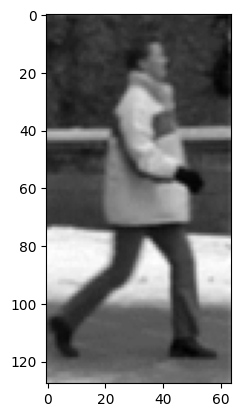

In [8]:
image = read_and_preprocess_image('images/person.png')
show_image(image)

## Ejercicio 2

In [9]:
def calcular_gradiente(imagen):
    imagen = preprocess_image(imagen)
    # Definir los filtros de Prewitt para calcular las correlaciones Gx y Gy
    filtro_prewitt_y = np.array([[-1, 0, 1],
                                  [-1, 0, 1],
                                  [-1, 0, 1]])
    filtro_prewitt_x = np.array([[-1, -1, -1],
                                  [0, 0, 0],
                                  [1, 1, 1]])

    # Realizar convolución de la imagen con los filtros de Prewitt
    gradiente_x = convolve2d(imagen, filtro_prewitt_x, mode='same', boundary='symm')
    gradiente_y = convolve2d(imagen, filtro_prewitt_y, mode='same', boundary='symm')

    # Calcular la magnitud del gradiente
    magnitud_gradiente = np.sqrt(gradiente_x**2 + gradiente_y**2)

    # Calcular el ángulo del gradiente en radianes
    angulo_gradiente = np.arctan2(gradiente_y, gradiente_x)

    # Convertir el ángulo a grados y asegurar que esté en el rango 0 <= θ < 180
    angulo_gradiente_grados = np.degrees(angulo_gradiente) % 180

    return magnitud_gradiente, angulo_gradiente_grados


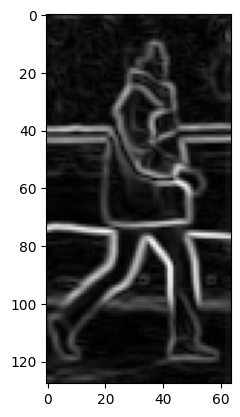

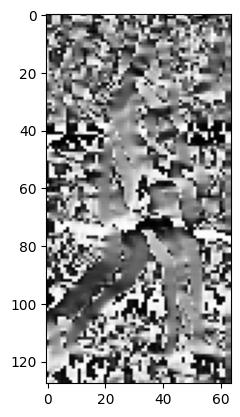

In [10]:
gradient_magnitude, gradient_angle = calcular_gradiente(image)
show_image(gradient_magnitude)
show_image(gradient_angle)

## Ejercicio 3

In [25]:
def build_block_stack(magnitud_gradiente, angulo_gradiente, block_size=8, stride=None):
    if stride is None:
        stride = block_size // 2
    # Calcular M y N según las fórmulas dadas
    M = magnitud_gradiente.shape[0] // (stride) - 1
    N = magnitud_gradiente.shape[1] // (stride) - 1

    # Inicializar los arrays para el stack de bloques de magnitud y ángulo del gradiente
    block_magnitude = np.zeros((M * N, block_size, block_size))
    block_angle = np.zeros((M * N, block_size, block_size))

    # Rellenar los arrays con los bloques de magnitud y ángulo del gradiente
    block_index = 0
    for y in range(M):
        for x in range(N):
            # Determinar la posición del bloque
            start_y = y * stride
            start_x = x * stride
            end_y = start_y + block_size
            end_x = start_x + block_size

            # Extraer los bloques de magnitud y ángulo y almacenarlos
            block_magnitude[block_index] = magnitud_gradiente[start_y:end_y, start_x:end_x]
            block_angle[block_index] = angulo_gradiente[start_y:end_y, start_x:end_x]

            block_index += 1

    return block_magnitude, block_angle


In [26]:
blocks_magnitude, blocks_angle = build_block_stack(gradient_magnitude, gradient_angle, stride=8)
print(blocks_magnitude.shape)

(105, 8, 8)


## Ejercicio 4

In [27]:
def construir_histograma_de_gradientes(block_magnitude, block_angle, num_bins=9):
    # Inicializar el array para el histograma de gradientes
    H = np.zeros((block_magnitude.shape[0], num_bins))

    # Calcular los centros de cada bin
    bin_centros = np.linspace(0, 180, num_bins + 1, endpoint=True)[1:-1]

    # Pequeña constante para evitar la división por cero
    epsilon = 1e-10

    # Iterar sobre los bloques en los stacks de bloques
    for i in range(block_magnitude.shape[0]):
        magnitudes = block_magnitude[i].flatten()  # Obtener las magnitudes del bloque
        angulos = block_angle[i].flatten()  # Obtener los ángulos del bloque

        # Calcular el histograma de gradientes para el bloque actual
        histograma = np.zeros(num_bins)
        for mag, ang in zip(magnitudes, angulos):
            # Calcular el bin correspondiente al ángulo
            indice_bin = int(ang // (180 / num_bins))
            if indice_bin == num_bins:
                indice_bin = num_bins - 1

            # Añadir la contribución de la magnitud al bin del histograma
            histograma[indice_bin] += mag

        # Normalizar el histograma utilizando la norma euclidiana
        norma = np.linalg.norm(histograma) + epsilon
        histograma /= norma

        # Asignar el histograma normalizado al array H
        H[i] = histograma

    return H

In [28]:
histograms = construir_histograma_de_gradientes(blocks_magnitude, blocks_angle)
print(histograms.shape)

(105, 9)


## Ejercicio 5

In [14]:
def draw_line(image, value, bin_num, num_bins, center, max_length):
    angle = (bin_num / num_bins) * 180
    radians = np.deg2rad(angle)
    end_x = int(center[0] + value * max_length * np.cos(radians))
    end_y = int(center[1] + value * max_length * np.sin(radians))
    cv2.line(image, center, (end_x, end_y), 255, 1)

def draw_histogram_block(histogram, block_size=8):
    max_length = block_size // 2
    num_bins = len(histogram)
    image = np.zeros((block_size, block_size), dtype=np.uint8)
    center = (block_size // 2, block_size // 2)
    
    for i, value in enumerate(histogram):
        normalized_value = value / max(histogram)  # Normalizar los valores para el tamaño del bloque
        draw_line(image, normalized_value, i, num_bins, center, max_length)
        
    return image

def draw_hog_visualization(histograms_matrix, image_shape, block_size=8):
    num_blocks_y, num_blocks_x = image_shape
    num_bins = histograms_matrix.shape[1]
    hog_image = np.zeros((num_blocks_y * block_size, num_blocks_x * block_size), dtype=np.uint8)
    
    for idx, histogram in enumerate(histograms_matrix):
        y = idx // num_blocks_x
        x = idx % num_blocks_x
        block_image = draw_histogram_block(histogram, block_size)
        hog_image[y * block_size:(y + 1) * block_size, x * block_size:(x + 1) * block_size] = block_image
    
    return hog_image

In [15]:
hog_image = draw_hog_visualization(histograms, image.shape)
show_image(hog_image)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_22644\3218148013.py:15: RuntimeWarning: invalid value encountered in double_scalars
  normalized_value = value / max(histogram)  # Normalizar los valores para el tamaño del bloque


ValueError: cannot convert float NaN to integer

## Ejercicio 6

In [ ]:
fd, hogI = hog(I, orientations=9, pixels-per-cell=(8, 8), cells per block=(2, 2), visualize=True)
plt.figure()
plt.imshow(hogI)
plt.show()

## Ejercicio 7

In [ ]:
# Cargar la imagen
I = cv2.imread('xxx.jpg')

# Crear un descriptor HOG
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())  # Método corregido

# Detectar peatones
locations, confidence = hog.detectMultiScale(I)

# Dibujar rectángulos alrededor de los peatones detectados
for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)

# Convertir la imagen a RGB para mostrarla con Matplotlib
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

# Mostrar la imagen
plt.figure(figsize=(20, 10))
plt.imshow(I_rgb)
plt.axis('off')
plt.show()
